# InSAR Denoiser training, validation, testing

In [42]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import glob
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sns

## Dataset Construction
intended file structure to ingest includes four dirs: train_image, train_label, test_image. Folders contain only images. 
- Filenames in image folders: sub1_S1AA_20190505T135154_20190622T135157_VVP048_INT80_G_weF_011A_los_disp.tif
- Filenames in label folders: sub1_S1AA_20190505T135154_20190622T135157_VVP048_INT80_G_weF_011A_los_disp.tif

In [49]:
train_fns = os.listdir('/Users/qbren/Desktop/uw_courses/2022_spring/inferring-structure/project/data_processing/data_crop/train')
test_fns = os.listdir('/Users/qbren/Desktop/uw_courses/2022_spring/inferring-structure/project/data_processing/data_crop/test') #change paths before use

def keep_tifs(my_fns):
    my_list = []
    for i in my_fns:
        if i[-4:] == '.tif':
            my_list.append(i)
    return my_list
        
    
train_list = keep_tifs(train_fns)
test_list = keep_tifs(test_fns)

In [50]:
train_list, val_list = train_test_split(train_list, test_size=0.2)

In [51]:
my_transforms = transforms.Compose([
    transforms.ToTensor() #because label is also an image that needs to match, can't do any flipping
])

In [52]:
# normalization between -1 and 1 as in Zhao et al. https://doi.org/10.1016/j.isprsjprs.2021.08.009

train_img_dir = '/Users/qbren/Desktop/uw_courses/2022_spring/inferring-structure/project/data_processing/data_crop/train/'
train_label_dir = '/Users/qbren/Desktop/uw_courses/2022_spring/inferring-structure/project/data_processing/data_crop/train_target/'
test_img_dir = '/Users/qbren/Desktop/uw_courses/2022_spring/inferring-structure/project/data_processing/data_crop/test/'
test_label_dir = '/Users/qbren/Desktop/uw_courses/2022_spring/inferring-structure/project/data_processing/data_crop/test_era5/'

class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list, img_dir, label_dir, transform=None, norm=True):
        self.file_list = file_list
        self.transform = transform
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.norm = norm
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load images
    def __getitem__(self,idx):
        img_path = self.img_dir+self.file_list[idx]
        label_path = self.label_dir+self.file_list[idx]
        img = Image.open(img_path)
        label = Image.open(label_path)
        img_transformed = self.transform(img)
        label_transformed = self.transform(label)
        
        # Perform normalization
        if self.norm == True:
            img_transformed = 2*(((img_transformed-img_transformed.min())/(img_transformed.max()-img_transformed.min())))-1
            label_transformed = 2*(((label_transformed-label_transformed.min())/(label_transformed.max()-label_transformed.min())))-1 
        
        return img_transformed, label_transformed

In [53]:
# create dataloaders
train_data = dataset(train_list, train_img_dir, train_label_dir, transform=my_transforms)
val_data = dataset(val_list, train_img_dir, train_label_dir, transform=my_transforms)
test_data = dataset(test_list, test_img_dir, test_label_dir, transform=my_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=64, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=1, shuffle=True)

## Model definition

In [29]:
# model from Zhang et al. https://doi.org/10.1109/TIP.2017.2662206, as implemented here: https://github.com/SaoYan/DnCNN-PyTorch 
class DnCNN(nn.Module):
    def __init__(self, channels, num_of_layers=12):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers = []
        layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
    def forward(self, x):
        out = self.dncnn(x)
        return out

## Train Model

In [30]:
%%time

#Define optimizer
model = DnCNN(channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #original implementation reduces learning rate at milestone 30 epochs
loss_fn   = nn.MSELoss() 
epochs = 30

train_loss = []
valid_loss = []

for epoch in range(epochs):
    print(f'\nstarting epoch {epoch}')
    epoch_loss=[]
    val_temp_loss = []
    
    #loop through training data 
    for (sample, target) in train_loader:
        model.train()
        optimizer.zero_grad()
        out = torch.clamp(sample - model(sample), -1, 1) #Generate noise predictions using the model, subtract from interferogram
        loss = loss_fn(out, target) #Loss/error
        epoch_loss.append(loss.item())
        loss.backward() #Propagate the gradients in backward pass
        optimizer.step()
        
    train_loss.append(np.mean(epoch_loss))
    print(f'training loss: {np.mean(epoch_loss)}')
    
    # run model on validation data 
    for (sample, target) in val_loader:
        with torch.no_grad():
            model.eval()
            out = torch.clamp(sample - model(sample), -1, 1) #Generate predictions using the model
            loss = loss_fn(out, target) #Loss/error
            val_temp_loss.append(loss.item())
    
    valid_loss.append(np.mean(val_temp_loss))
    print(f'validation loss: {np.mean(val_temp_loss)}')


starting epoch 0
training loss: 0.06850902816733799
validation loss: 0.06721690922443356

starting epoch 1
training loss: 0.06575540574015798
validation loss: 0.06770243030041456

starting epoch 2
training loss: 0.0657261778172609
validation loss: 0.06634991429746151

starting epoch 3
training loss: 0.06566137528500042
validation loss: 0.06626851071736642

starting epoch 4
training loss: 0.06546858245053806
validation loss: 0.06627297201859099

starting epoch 5


KeyboardInterrupt: 

### Plot loss

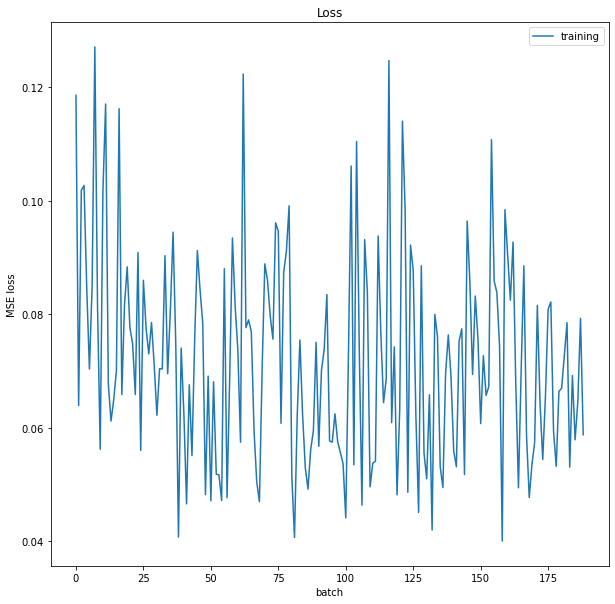

In [24]:
# Plot loss
f, ax = plt.subplots(figsize=(10,10))
ax.plot(epoch_loss, label='training')
ax.set_xlabel('batch')
ax.set_ylabel('MSE loss')
ax.set_title('Loss')
ax.legend()

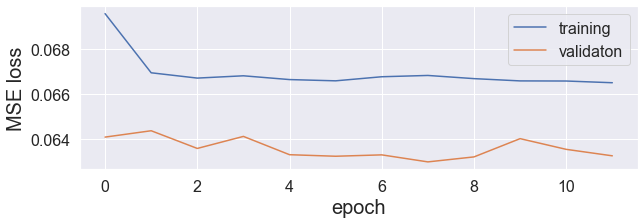

In [113]:
# Plot loss
# run 1 loss: 
r1_train_loss = [0.06959520985145827, 0.06695907509273237, 0.06672255654592772, 0.06682496242695027, 0.06665660793314108, 0.06660070475023072, 0.0667824328684055, 0.06684046158113995, 0.0666985778926729, 0.06659741887638161, 0.0665921041624503, 0.06651572513956207]
r1_val_loss = [0.06409293546208314, 0.06437609970037426, 0.06358764985842365, 0.06412387679197959, 0.06330868601799011, 0.06323979369231633, 0.06330125978482622, 0.06298834750694889, 0.0632102916549359, 0.06402413187814611, 0.0635471204295754, 0.0632584991731814]

sns.set_theme()

f, ax = plt.subplots(figsize=(10,3))
ax.plot(r1_train_loss, label='training')
ax.plot(r1_val_loss, label='validaton')
ax.set_xlabel('epoch', fontsize=20)
ax.set_ylabel('MSE loss', fontsize=20)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16)

f.savefig('r1_loss.png')

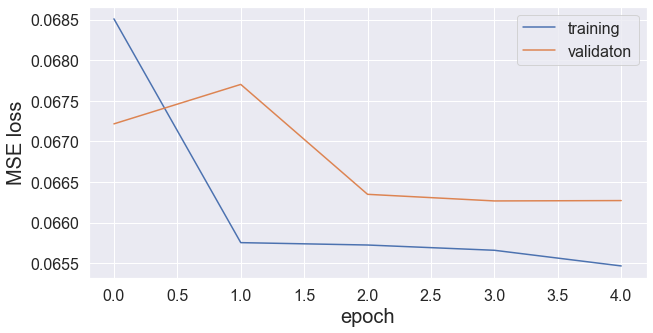

In [32]:
f, ax = plt.subplots(figsize=(10,5))
ax.plot(train_loss, label='training')
ax.plot(valid_loss, label='validaton')
ax.set_xlabel('epoch', fontsize=20)
ax.set_ylabel('MSE loss', fontsize=20)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16)

f.savefig('r1_loss.png')

### Visualize outputs 

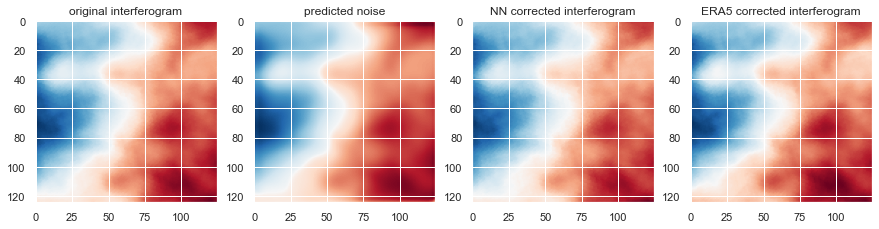

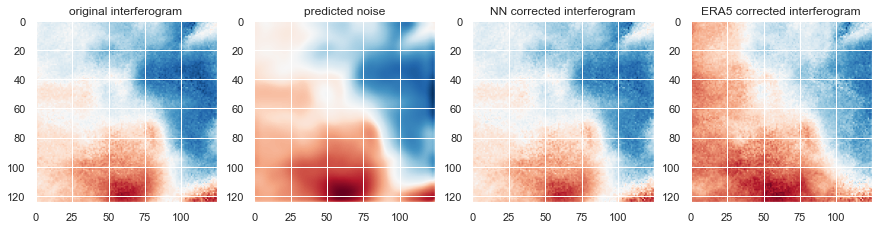

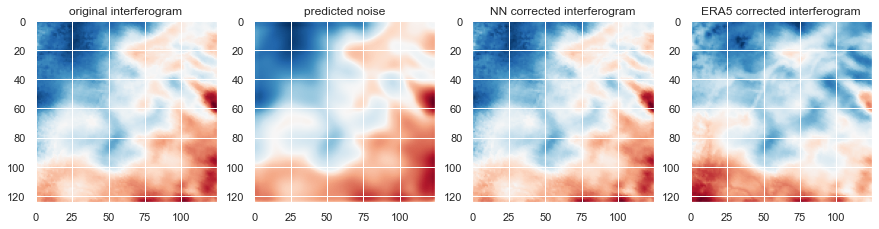

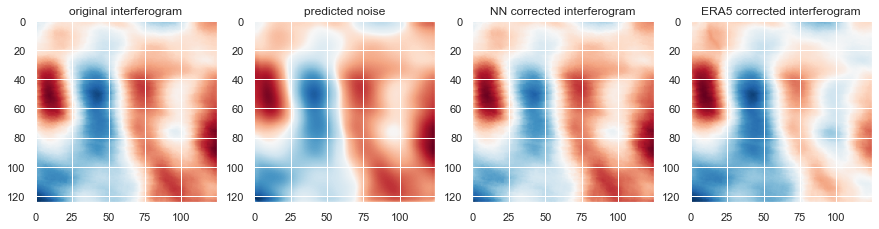

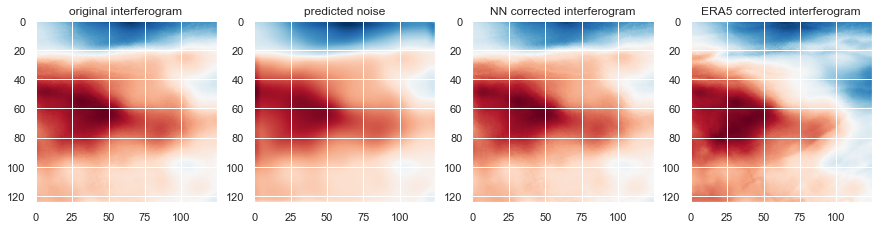

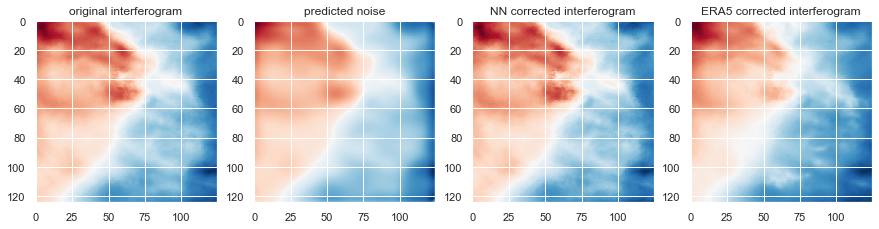

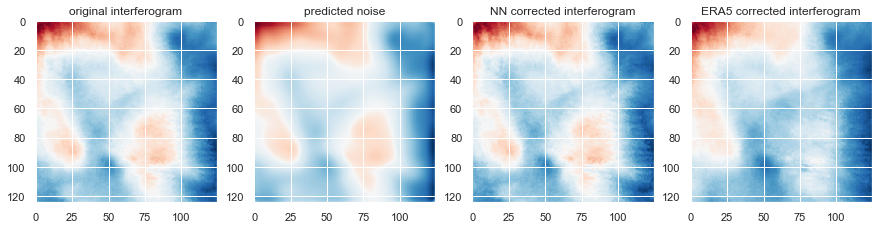

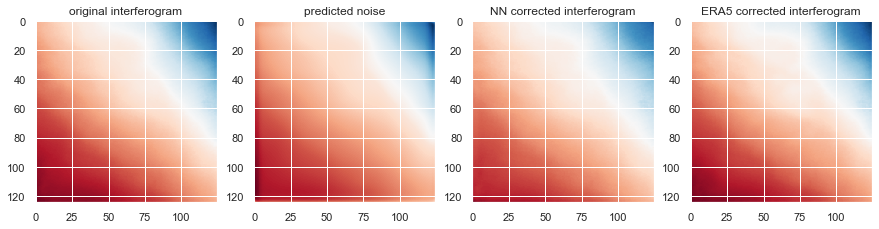

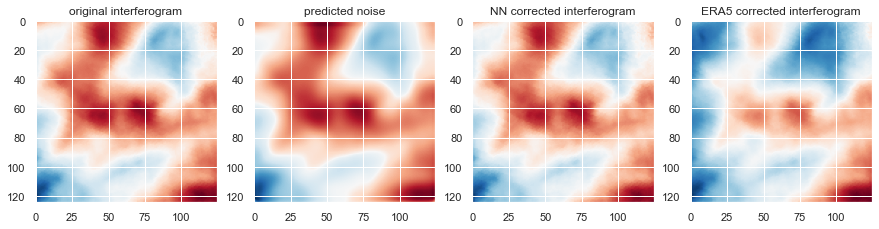

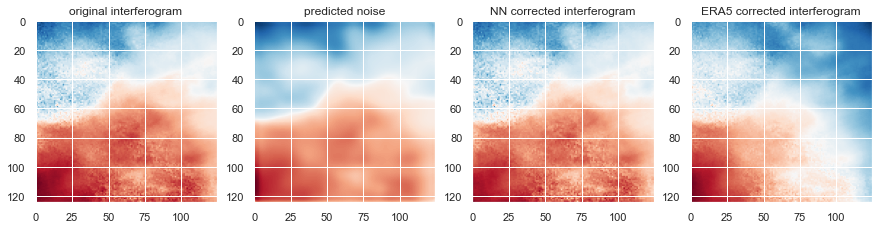

In [41]:
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=1, shuffle=True) #change batch size

num_images = 10

for i, (sample, target) in enumerate(val_loader):
    if i < num_images:
        with torch.no_grad():
            noise = model(sample) #Generate predictions using the model
            nn_corrected = torch.clamp(sample - noise, -1, 1)
            
            f, ax = plt.subplots(1, 4, figsize=(15,5))
            ax[0].imshow(sample.squeeze(), cmap='RdBu') #will probably need to fix this
            ax[0].set_title('original interferogram')
            ax[1].imshow(noise.squeeze(), cmap='RdBu')
            ax[1].set_title('predicted noise')
            ax[2].imshow(nn_corrected.squeeze(), cmap='RdBu')
            ax[2].set_title('NN corrected interferogram')
            ax[3].imshow(target.squeeze(), cmap='RdBu')
            ax[3].set_title('ERA5 corrected interferogram')

# Test Model

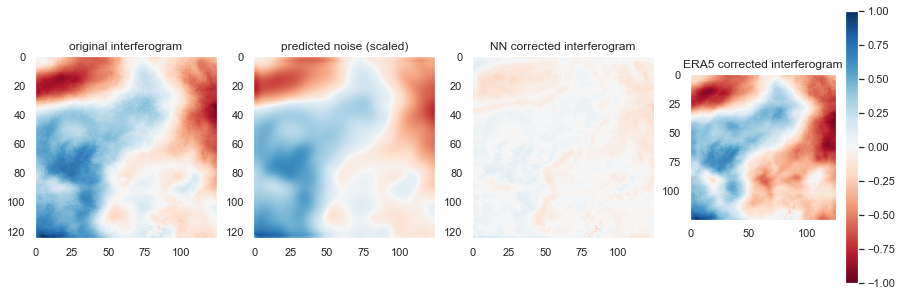

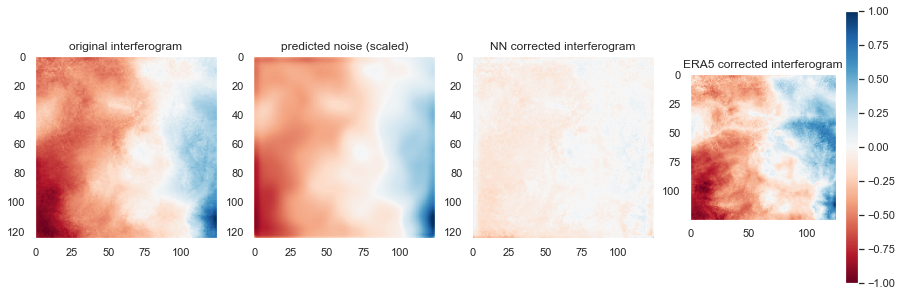

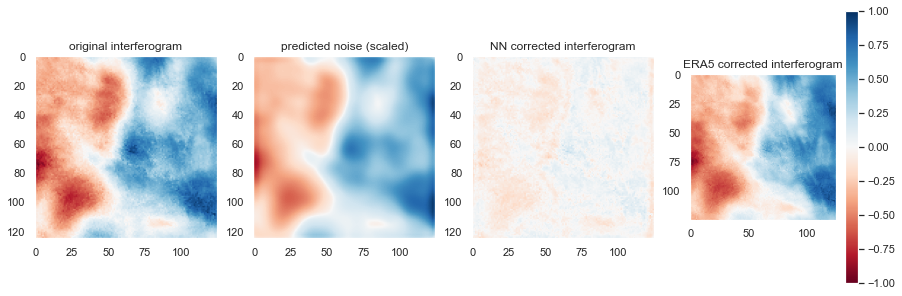

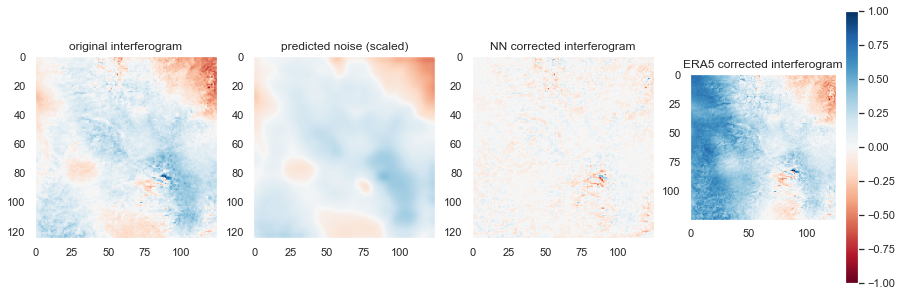

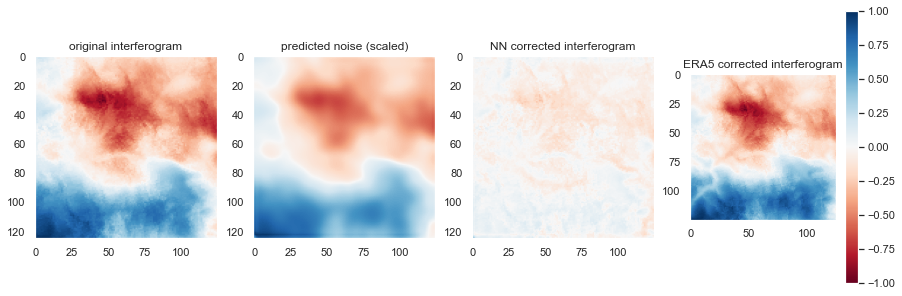

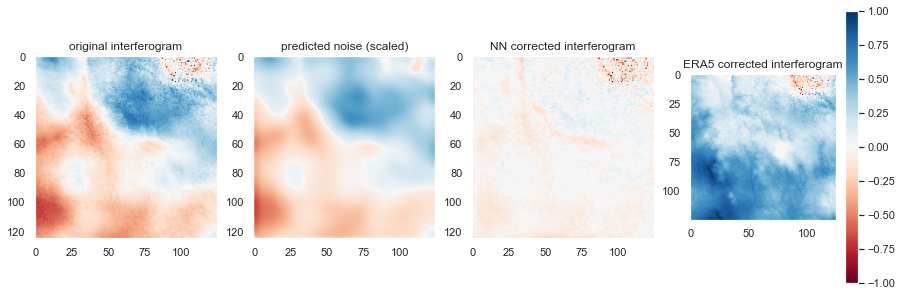

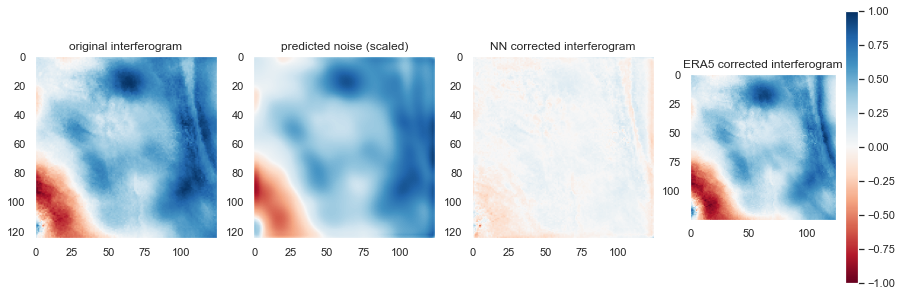

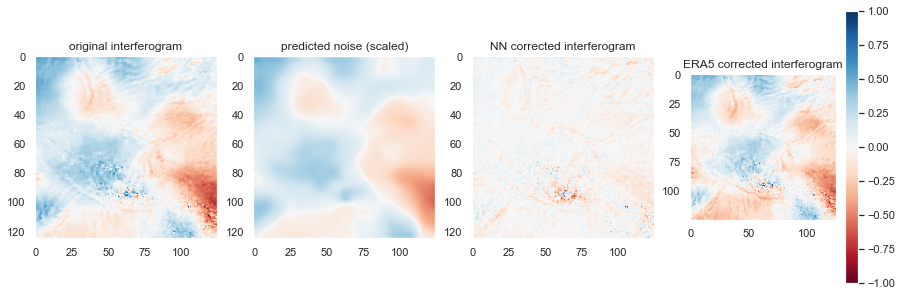

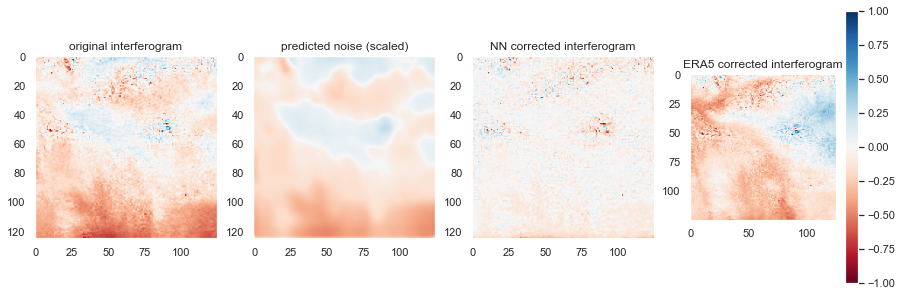

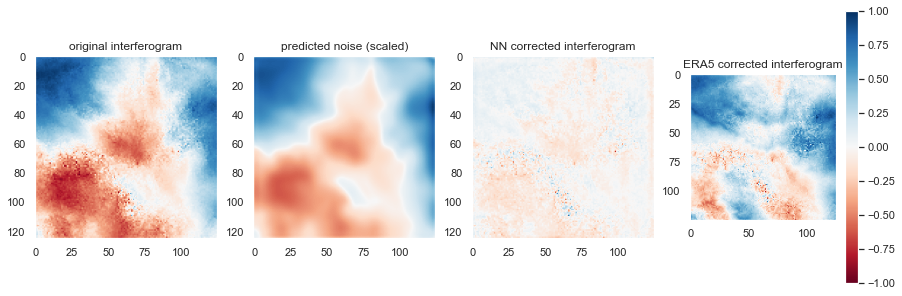

In [112]:
num_images = 10

for i, (sample, target) in enumerate(test_loader):
    if i < num_images:
        with torch.no_grad():
            noise = model(sample) #Generate predictions using the model
            nn_corrected = torch.clamp(sample - 4*noise, -1, 1)
            
            f, ax = plt.subplots(1, 4, figsize=(15,5))
            img0 = ax[0].imshow(sample.squeeze(), cmap='RdBu', vmax=1, vmin=-1)
            ax[0].grid(False)
            ax[0].set_title('original interferogram')
            img1 = ax[1].imshow(noise.squeeze()*4, cmap='RdBu', vmax=1, vmin=-1)
            ax[1].set_title('predicted noise (scaled)')
            ax[1].grid(False)
            img2 = ax[2].imshow(nn_corrected.squeeze(), cmap='RdBu', vmax=1, vmin=-1)
            ax[2].set_title('NN corrected interferogram')
            ax[2].grid(False)
            img3 = ax[3].imshow(target.squeeze(), cmap='RdBu', vmax=1, vmin=-1)
            ax[3].set_title('ERA5 corrected interferogram')
            ax[3].grid(False)
            plt.colorbar(img3, ax=ax[3])

num_images = 10
max_val = 0.5
min_val = -0.5


for i, (sample, target) in enumerate(test_loader):
        with torch.no_grad():
            noise = model(sample) #Generate predictions using the model
            nn_corrected = torch.clamp(sample - 4*noise, -1, 1)
            
            if nn_corrected.squeeze().max() > max_val:
                f, ax = plt.subplots(1, 4, figsize=(15,5))
                ax[0].imshow(sample.squeeze(), cmap='RdBu', vmax=1, vmin=-1)
                ax[0].grid(False)
                ax[0].set_title('original interferogram')
                ax[1].imshow(noise.squeeze()*4, cmap='RdBu', vmax=1, vmin=-1)
                ax[1].set_title('predicted noise (scaled)')
                ax[1].grid(False)
                ax[2].imshow(nn_corrected.squeeze(), cmap='RdBu', vmax=1, vmin=-1)
                ax[2].set_title('NN corrected interferogram')
                ax[2].grid(False)
                ax[3].imshow(target.squeeze(), cmap='RdBu', vmax=1, vmin=-1)
                ax[3].set_title('ERA5 corrected interferogram')
                ax[3].grid(False)
                
            elif nn_corrected.squeeze().min() < min_val:
                f, ax = plt.subplots(1, 4, figsize=(15,5))
                ax[0].imshow(sample.squeeze(), cmap='RdBu', vmax=1, vmin=-1)
                ax[0].grid(False)
                ax[0].set_title('original interferogram')
                ax[1].imshow(noise.squeeze()*4, cmap='RdBu', vmax=1, vmin=-1)
                ax[1].set_title('predicted noise (scaled)')
                ax[1].grid(False)
                ax[2].imshow(nn_corrected.squeeze(), cmap='RdBu', vmax=1, vmin=-1)
                ax[2].set_title('NN corrected interferogram')
                ax[2].grid(False)
                ax[3].imshow(target.squeeze(), cmap='RdBu', vmax=1, vmin=-1)
                ax[3].set_title('ERA5 corrected interferogram')
                ax[3].grid(False)